In [1]:
!pip install opencv-python --quiet

In [2]:
!pip install sklearn --quiet

In [3]:
!pip install pillow --quiet

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from glob import glob
import time

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
from tensorflow import keras

In [5]:
# function to display images 

def load_images(path):
    images = []
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))
        if img is not None:
            images.append(img)
        if len(images)>1:
            break
    fig=plt.figure(figsize=(5,5))
    xrange=range(1,5)
    
    for img,x in zip(images,xrange):
        ax=fig.add_subplot(2,2,x)
        ax.imshow(img)
        ax.set_title(img.shape)

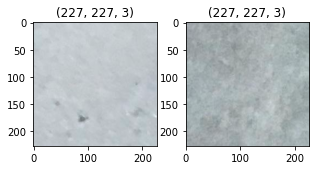

In [6]:
load_images("../cracks_data/Negative")

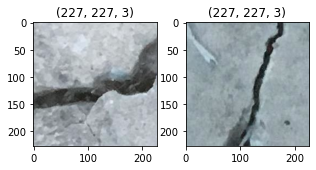

In [7]:
load_images("../cracks_data/Positive")

### Set hyper-parameters

In [8]:
n_epochs = 100   # Number of epochs
n_layers = 3   # Number of random layers
n = 600    # Size of the dataset

SAVE_PATH = "../working/" # Data saving folder
PREPROCESS = False           # If False, skip quantum reprocessing and load saved data
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator
qubits=5

### Prepare the Dataset

In [9]:
def generate_df(path_negative,path_positive):
    df_negative = pd.DataFrame(columns=( 'path', 'image', 'label'),index=np.arange(0,20000))
    df_positive = pd.DataFrame(columns=( 'path', 'image', 'label'),index=np.arange(0,20000))
    
    image_path_dict_negative = np.array([x for x in glob(os.path.join(path_negative, '*.jpg'))])
    image_path_dict_positive = np.array([x for x in glob(os.path.join(path_positive, '*.jpg'))])

    df_negative['path']=image_path_dict_negative
    df_negative = df_negative[:n]  # Reduce the data
    df_negative['label']=0
    df_negative['image']=df_negative['path'].map(lambda x: np.asarray(Image.open(x).resize((227,227))))

    df_positive['path']=image_path_dict_positive
    df_positive = df_positive[:n]  # Reduce the data
    df_positive['label']=1
    df_positive['image']=df_positive['path'].map(lambda x: np.asarray(Image.open(x).resize((227,227))))

    print("Negative:",df_negative["image"][0].shape)
    print("Positive:",df_positive["image"][0].shape)

    df = pd.concat([df_positive, df_negative], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
    print(df.shape)
    return df

In [10]:
#if PREPROCESS == True:
path_negative = "../cracks_data/Negative"
path_positive = "../cracks_data/Positive"

df = generate_df(path_negative,path_positive)
#df.to_pickle('cracks_df')
df.head()

Negative: (227, 227, 3)
Positive: (227, 227, 3)
(1200, 3)


,path,image,label
0,../cracks_data/Negative/04305.jpg,"[[[174, 171, 166], [177, 174, 169], [180, 177,...",0
1,../cracks_data/Negative/16399.jpg,"[[[208, 205, 200], [206, 203, 198], [203, 200,...",0
2,../cracks_data/Negative/16499.jpg,"[[[171, 168, 161], [175, 172, 165], [180, 177,...",0
3,../cracks_data/Positive/04760.jpg,"[[[169, 165, 154], [170, 166, 155], [173, 169,...",1
4,../cracks_data/Negative/16401.jpg,"[[[228, 219, 210], [225, 216, 207], [221, 212,...",0


In [11]:
#df = pd.read_pickle('cracks_df')
df_new = df.drop(columns=['path'],axis=1)
x = df_new.drop(columns=['label'],axis=1)
y = df_new.drop(columns=['image'],axis=1)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,random_state=123)

In [13]:
x_train.shape

(960, 1)

In [14]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

In [15]:
x_train.shape

(960, 227, 227, 3)

In [16]:
# Normalize pixel values within 0 and 1
x_train = x_train / 255
x_test = x_test / 255

In [17]:
# Add extra dimension for convolution channels
x_train = np.array(x_train[..., tf.newaxis], requires_grad=False)
x_test = np.array(x_test[..., tf.newaxis], requires_grad=False)

#### Initialize a quantum device/Simulator

In [18]:
from braket.aws import AwsDevice

In [19]:
# to get the managed simulators
AwsDevice.get_devices(types=['SIMULATOR'])

[Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1),
 Device('name': TN1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/tn1),
 Device('name': dm1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/dm1)]

In [20]:
# to get the list of QPUs
AwsDevice.get_devices(types=['QPU'])

[Device('name': Advantage_system1.1, 'arn': arn:aws:braket:::device/qpu/d-wave/Advantage_system1),
 Device('name': Aspen-8, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-8),
 Device('name': Aspen-9, 'arn': arn:aws:braket:::device/qpu/rigetti/Aspen-9),
 Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6),
 Device('name': IonQ Device, 'arn': arn:aws:braket:::device/qpu/ionq/ionQdevice)]

In [21]:
#dev = qml.device("default.qubit", wires=qubits) #304.5835340023041
#dev = qml.device("default.qubit.tf", wires=qubits) #785.0144665241241
dev = qml.device("default.qubit.autograd", wires=qubits)#302.9258511066437

In [22]:
my_bucket = f"amazon-braket-52e22b396243" # the name of the bucket
my_prefix = "qpu_logs" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

device_arn = "arn:aws:braket:::device/qpu/ionq/ionQdevice"

dev_remote = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=qubits,
    s3_destination_folder=s3_folder,
    parallel=True,
)

Now we define the quantum circuit using the qnode decorator

In [23]:
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, qubits))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

Function to define the quanvolutional layer for the circuit

In [24]:
def quanv(image):
    out = np.zeros((14, 14, 4))
    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Preprocess the data in the quantum circuits & save for reuse

In [25]:
t_0_remote = time.time()

if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(x_train):
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(x_test):
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

t_1_remote = time.time()

In [26]:
print("Execution time on the device (seconds):", t_1_remote - t_0_remote)
# print("Execution time on local device (seconds):", t_1_local - t_0_local)

Execution time on the device (seconds): 0.03005838394165039


Function to define the Keras model

In [27]:
def model():
    """Initializes and returns a custom Keras model"""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(optimizer='adam',loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

Train the model on data output from quantum convolutional layer

In [28]:
q_model = model()
qhistory = q_model.fit(
    q_train_images,
    y_train,
    validation_data=(q_test_images, y_test),
    batch_size=1,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/100
960/960 - 2s - loss: 0.7376 - accuracy: 0.5406 - val_loss: 0.6621 - val_accuracy: 0.6042
Epoch 2/100
960/960 - 1s - loss: 0.6977 - accuracy: 0.5781 - val_loss: 0.7714 - val_accuracy: 0.5125
Epoch 3/100
960/960 - 1s - loss: 0.7227 - accuracy: 0.5573 - val_loss: 0.6812 - val_accuracy: 0.5917
Epoch 4/100
960/960 - 1s - loss: 0.6823 - accuracy: 0.5656 - val_loss: 0.7599 - val_accuracy: 0.5458
Epoch 5/100
960/960 - 1s - loss: 0.7050 - accuracy: 0.5740 - val_loss: 0.6947 - val_accuracy: 0.5625
Epoch 6/100
960/960 - 1s - loss: 0.6741 - accuracy: 0.6073 - val_loss: 0.6614 - val_accuracy: 0.5875
Epoch 7/100
960/960 - 1s - loss: 0.6816 - accuracy: 0.5760 - val_loss: 0.8807 - val_accuracy: 0.5458
Epoch 8/100
960/960 - 1s - loss: 0.6844 - accuracy: 0.5823 - val_loss: 0.6681 - val_accuracy: 0.5667
Epoch 9/100
960/960 - 1s - loss: 0.6815 - accuracy: 0.5979 - val_loss: 0.7506 - val_accuracy: 0.5750
Epoch 10/100
960/960 - 1s - loss: 0.6872 - accuracy: 0.6187 - val_loss: 0.6831 - val_accura

Epoch 82/100
960/960 - 1s - loss: 0.6057 - accuracy: 0.6760 - val_loss: 0.7390 - val_accuracy: 0.5583
Epoch 83/100
960/960 - 1s - loss: 0.6090 - accuracy: 0.6635 - val_loss: 0.7067 - val_accuracy: 0.5750
Epoch 84/100
960/960 - 1s - loss: 0.6181 - accuracy: 0.6656 - val_loss: 0.7177 - val_accuracy: 0.5750
Epoch 85/100
960/960 - 1s - loss: 0.6251 - accuracy: 0.6604 - val_loss: 0.7704 - val_accuracy: 0.5250
Epoch 86/100
960/960 - 1s - loss: 0.6144 - accuracy: 0.6750 - val_loss: 0.7659 - val_accuracy: 0.6083
Epoch 87/100
960/960 - 1s - loss: 0.6069 - accuracy: 0.6552 - val_loss: 0.6813 - val_accuracy: 0.5875
Epoch 88/100
960/960 - 1s - loss: 0.6045 - accuracy: 0.6552 - val_loss: 0.6877 - val_accuracy: 0.5708
Epoch 89/100
960/960 - 1s - loss: 0.6170 - accuracy: 0.6687 - val_loss: 0.6896 - val_accuracy: 0.5667
Epoch 90/100
960/960 - 1s - loss: 0.6180 - accuracy: 0.6469 - val_loss: 0.6952 - val_accuracy: 0.5958
Epoch 91/100
960/960 - 1s - loss: 0.6089 - accuracy: 0.6531 - val_loss: 0.6900 - v

Train the model on classical data

In [ ]:
c_model = model()
chistory = c_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/100
96/96 - 3s - loss: 17.4219 - accuracy: 0.5354 - val_loss: 11.4193 - val_accuracy: 0.5083
Epoch 2/100
96/96 - 1s - loss: 12.7303 - accuracy: 0.5802 - val_loss: 0.9000 - val_accuracy: 0.8708
Epoch 3/100
96/96 - 1s - loss: 4.2967 - accuracy: 0.6854 - val_loss: 10.2399 - val_accuracy: 0.5542
Epoch 4/100
96/96 - 1s - loss: 8.1100 - accuracy: 0.6500 - val_loss: 5.5946 - val_accuracy: 0.6708
Epoch 5/100
96/96 - 1s - loss: 3.3841 - accuracy: 0.7396 - val_loss: 0.7288 - val_accuracy: 0.8292
Epoch 6/100
96/96 - 1s - loss: 4.7441 - accuracy: 0.7458 - val_loss: 3.2592 - val_accuracy: 0.7417
Epoch 7/100
96/96 - 1s - loss: 6.7268 - accuracy: 0.6833 - val_loss: 17.3871 - val_accuracy: 0.5417
Epoch 8/100
96/96 - 1s - loss: 3.8768 - accuracy: 0.7500 - val_loss: 1.0473 - val_accuracy: 0.8042
Epoch 9/100
96/96 - 1s - loss: 3.7691 - accuracy: 0.7500 - val_loss: 27.6203 - val_accuracy: 0.5167
Epoch 10/100
96/96 - 1s - loss: 7.8908 - accuracy: 0.7094 - val_loss: 7.0850 - val_accuracy: 0.5083
Epo

Epoch 83/100
96/96 - 1s - loss: 6.5332 - accuracy: 0.8125 - val_loss: 4.2460 - val_accuracy: 0.8792
Epoch 84/100
96/96 - 1s - loss: 3.5639 - accuracy: 0.8604 - val_loss: 21.5263 - val_accuracy: 0.6500
Epoch 85/100
96/96 - 1s - loss: 3.6668 - accuracy: 0.8687 - val_loss: 2.3285 - val_accuracy: 0.9042
Epoch 86/100
96/96 - 1s - loss: 1.4502 - accuracy: 0.9073 - val_loss: 4.0898 - val_accuracy: 0.6833
Epoch 87/100
96/96 - 1s - loss: 2.6502 - accuracy: 0.8677 - val_loss: 2.5721 - val_accuracy: 0.8000
Epoch 88/100
96/96 - 1s - loss: 3.0598 - accuracy: 0.8792 - val_loss: 2.3856 - val_accuracy: 0.9125
Epoch 89/100
96/96 - 1s - loss: 7.4012 - accuracy: 0.8458 - val_loss: 15.2492 - val_accuracy: 0.7250
Epoch 90/100
96/96 - 1s - loss: 3.8736 - accuracy: 0.8677 - val_loss: 8.3991 - val_accuracy: 0.5583
Epoch 91/100


In [ ]:
plt.style.use("seaborn")
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

ax1.plot(qhistory.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(chistory.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

# ax2.plot(qhistory.history["val_loss"], "-ob", label="With quantum layer")
# ax2.plot(chistory.history["val_loss"], "-og", label="Without quantum layer")
# ax2.set_ylabel("Loss")
# ax2.set_ylim(top=2.5)
# ax2.set_xlabel("Epoch")
# ax2.legend()
# plt.tight_layout()
plt.show()